# Project 2
Group members: Lena Jörg, Sigurd Kolltveit, Gregor Moe

In [38]:
%pip install autograd


Note: you may need to restart the kernel to use updated packages.


In [39]:
#import numpy as np
import autograd.numpy as np  # required for automatic differentiation
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Model system 3.1 - 2D charged particle

In [40]:
def B_particle(x):
    x1 = x[0]
    x2 = x[1]
    return np.array([0,0,np.sqrt(x1**2+x2**2)])

def A_particle(x):
    x1 = x[0]
    x2 = x[1]
    return np.array([-x2*np.sqrt(x1**2+x2**2), x1*np.sqrt(x1**2+x2**2), 0])/3

def U_particle(x):
    x1 = x[0]
    x2 = x[1]
    return 1/(100*np.sqrt(x1**2 + x2**2))

def gradU_particle(x):
    x1 = x[0]
    x2 = x[1]
    u0 = x1/((x1**2 + x2**2)**(3/2))
    u1 = x2/((x1**2 + x2**2)**(3/2))
    return np.array([u0,u1,0])/(-100)

x0_particle = np.array([0.0, 1.0, 0.1], dtype=float)
v0_particle = np.array([0.09, 0.05, 0.20], dtype=float) 

In [41]:
#import numpy as np
import autograd.numpy as np  # required for automatic differentiation
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Model system 3.2 - Tokamak magnetic field

In [42]:
def B_tokamak(x):
    x1,x2,x3 = x
    b1 = -(2*x1 + x1*x3)/(2*(x1**2+x2**2))
    b2 = (2*x1 - x2*x3)/(2*(x1**2+x2**2))
    b3 = (np.sqrt(x1**2 + x2**2) - 1)/(2*np.sqrt(x1**2+x2**2))
    return np.array([b1, b2, b3])

def A_tokamak(x):
    x1,x2,x3 = x
    a2 = (x1 - np.log(np.sqrt(x1**2 + x2**2) + x1))/2
    a3 = (x3*np.arctan2(x2, x1) + np.log(x1**2 + x2**2))/(-2)
    return np.array([0, a2, a3])

def U_tokamak(x):
    return 0

def gradU_tokamak(x):
    return np.array([0, 0, 0])

x0_tokamak = np.array([1.2, 0, 0], dtype=float)
v0_tokamak = np.array([0, 4.816e-4, -2.059e-3], dtype=float)

### Boris method implementation

In [43]:
def boris_step(x, v_half, h, B, gradU):
    v_minus = v_half - 0.5 * h * gradU(x)

    t = 0.5 * h * B(x)
    t_mag2 = np.dot(t, t)

    v_prime = v_minus + np.cross(v_minus, t)
    s = 2 * t / (1 + t_mag2)

    v_plus = v_minus + np.cross(v_prime, s)
    v_half_next = v_plus - 0.5 * h * gradU(x)

    x_next = x + h * v_half_next
    return x_next, v_half_next


def initialize_v_half(x0, v0, h, B, gradU):
    def rhs(t, y):
        x, v = y[:3], y[3:]
        return np.concatenate([v, np.cross(v, B(x)) - gradU(x)])
    
    sol = solve_ivp(rhs, [0, -h/2], np.concatenate([x0, v0]), rtol=1e-10, atol=1e-12)
    return sol.y[3:, -1]


def boris_integrate(x0, v0, T, h, B, gradU):
    N = int(T/h)
    x = np.zeros((N+1, 3))
    v_half = np.zeros((N+1, 3))

    x[0] = x0
    v_half[0] = initialize_v_half(x0, v0, h, B, gradU)

    for n in range(N):
        x[n+1], v_half[n+1] = boris_step(x[n], v_half[n], h, B, gradU)

    return x, v_half

In [44]:
def v_integer(v_half):
    return 0.5 * (v_half[:-1] + v_half[1:])


# 1) Run the Boris method for both systems
h = 0.1
T = 100   # Small test simulation

x_2D, v_half_2D = boris_integrate(x0_particle, v0_particle, T, h, B_particle, gradU_particle)
x_tok, v_half_tok = boris_integrate(x0_tokamak, v0_tokamak, T, h, B_tokamak, gradU_tokamak)

# 2) Convert half-step velocities to integer-step velocities
def v_integer(v_half):
    return 0.5 * (v_half[:-1] + v_half[1:])

v_2D = v_integer(v_half_2D)
v_tok = v_integer(v_half_tok)

Trajectory plot for system 3.1 (2D charged particle)

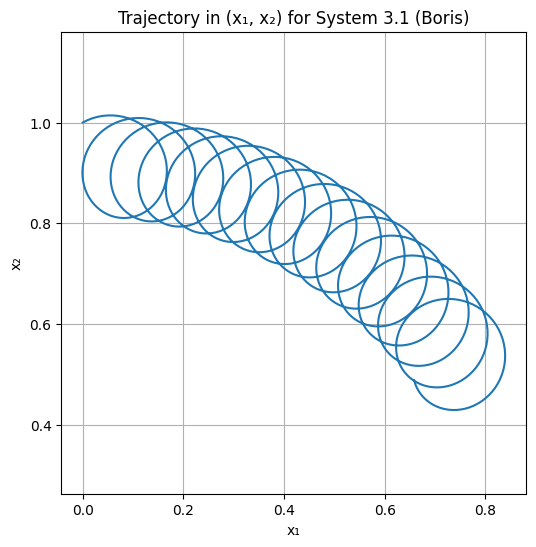

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(x_2D[:,0], x_2D[:,1])
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.title("Trajectory in (x₁, x₂) for System 3.1 (Boris)")
plt.axis("equal")
plt.grid(True)
plt.show()


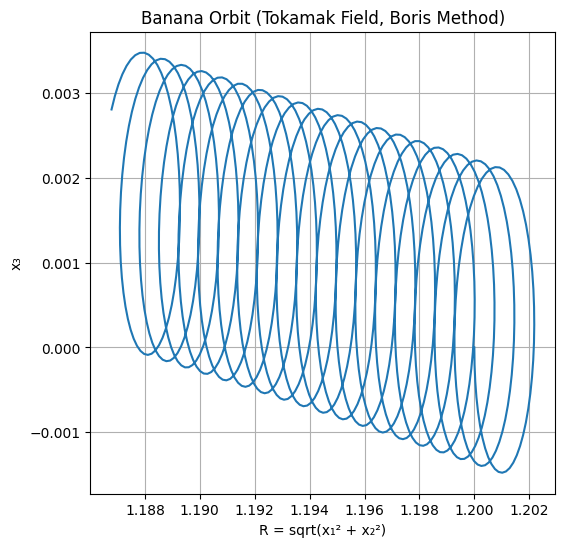

In [46]:
R_tok = np.sqrt(x_tok[:,0]**2 + x_tok[:,1]**2)  # Radial distance

plt.figure(figsize=(6,6))
plt.plot(R_tok, x_tok[:,2])
plt.xlabel("R = sqrt(x₁² + x₂²)")
plt.ylabel("x₃")
plt.title("Banana Orbit (Tokamak Field, Boris Method)")
plt.grid(True)
plt.show()

### Runge-Kutta 4 implementation

In [47]:
def rk4_step(x_prev,v_prev,h,f):
    kx1 = h*v_prev
    kv1 = h*f(x_prev,v_prev)

    kx2 = h*(v_prev + kv1/2)
    kv2 = h*f(x_prev + kx1/2, v_prev + kv1/2)

    kx3 = h*(v_prev + kv2/2)
    kv3 = h*f(x_prev + kx2/2, v_prev + kv2/2)

    kx4 = h*(v_prev + kv3)
    kv4 = h*f(x_prev + kx3, v_prev + kv3)

    v = v_prev + (kv1 + 2*kv2 + 2*kv3 + kv4)/6
    x = x_prev + (kx1 + 2*kx2 + 2*kx3 + kx4)/6
    return x, v

def rk4(Tmax,h, x0, v0, B_func, A_func, U_func, gradU_func):
    maxiter = int(Tmax/h)

    xs = np.zeros((maxiter,3))
    vs = np.zeros((maxiter,3))
    xs[0] = x0
    vs[0] = v0
    f = lambda x,v: np.cross(v,B_func(x)) - gradU_func(x)
    
    i = 1 
    while i<maxiter: #regner denne iterasjonen
        xs[i], vs[i] = rk4_step(xs[i-1],vs[i-1],h,f)
        i += 1
    return xs, vs

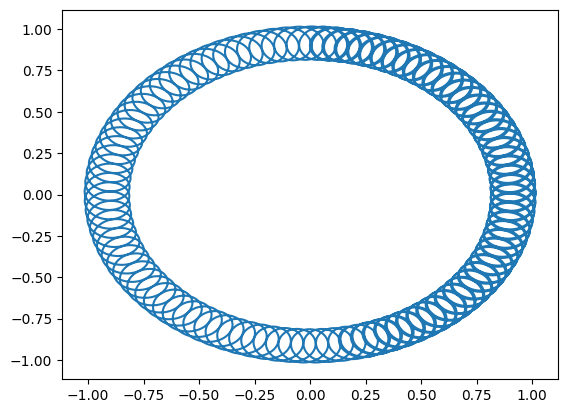

In [48]:
rk4_particle_sol = rk4(10**3, .1, x0_particle, v0_particle, B_particle, A_particle, U_particle, gradU_particle)
plt.plot(rk4_particle_sol[0][:,0],rk4_particle_sol[0][:,1])

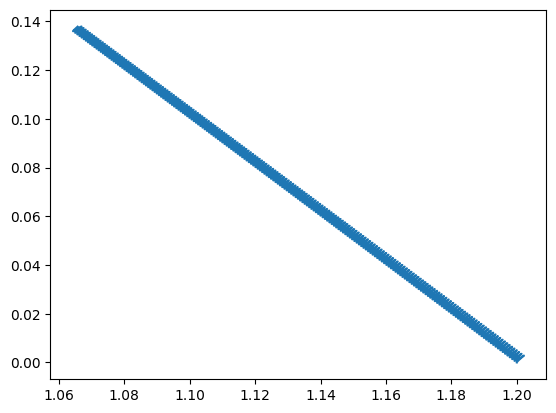

In [49]:
rk4_tokamak_sol = rk4(10**3, 0.1, x0_tokamak, v0_tokamak, B_tokamak, A_tokamak, U_tokamak, gradU_tokamak)
plt.plot(rk4_tokamak_sol[0][:,0], rk4_tokamak_sol[0][:,1])

### Fourth-order symmetric multistep method

In [50]:
from scipy.integrate import solve_ivp


# uses solve_ivp to get the initial n points of the solution
def initial_soln(x0, v0, B, gradU, h, Tmax):
    n = int(Tmax / h)
    def rhs(t, y):
        x, v = y[:3], y[3:]
        return np.concatenate([v, np.cross(v, B(x)) - gradU(x)])

    ts = [k * h for k in range(n)] # we only want the soln at these points
    res = solve_ivp(rhs, (0, h*n), [*x0, *v0], t_eval=ts, rtol=1e-10, atol=1e-12)
    x = res.y[:3].transpose()
    v = res.y[3:].transpose()
    return x, v



In [51]:
from autograd import jacobian


A_particle_jacobian = jacobian(A_particle)
A_tokamak_jacobian = jacobian(A_tokamak)

# calculates the five-point central difference of the array y at j
def Δ(y, j, f=lambda x: x):
    return (1/12) * (f(y[j-2]) - 8*f(y[j-1]) + 8*f(y[j+1]) - f(y[j+2]))


def fourth_order_multistep(x0, v0, B, A, A_diff, gradU, h, Tmax):
    n = int(Tmax / h)
    def F(j, x, v):
        v[j] = Δ(x, j)/h
        A_delta_j = Δ(x, j, A)/h

        F_j = A_diff(x[j]).transpose() @ v[j] - A_delta_j - gradU(x[j])
        return F_j


    a1, a2, a3 = -0.7, 0.1, 0.9
    beta0 = (1/3) * (20*a1*a2*a3 - 4*(a1*a2 + a1*a3 + a2*a3) - 28*(a1 + a2 + a3) - 52)
    beta1 = (1/3) * (2*a1*a2*a3 + 14*(a1*a2 + a1*a3 + a2*a3) + 26*(a1 + a2 + a3) + 38)
    alpha = (1, -7/5, 9/25, 22/125, -34/125, 22/125, 9/25, -7/5, 1)

    x, v = initial_soln(x0, v0, B, gradU, h, 8 * h) # get initial 8 points

    # pad with zeroes on the right
    x = np.pad(x, ((0, n-8), (0, 0)))
    v = np.pad(v, ((0, n-8), (0, 0)))
    assert v.shape == x.shape == (n, 3)

    for n in range(4, n-4):
        other_xs = sum(alpha[j+4]*x[n+j] for j in range(-4, 4))  # j = 4 is omitted from this sum
        Fnmin1 = F(n-1, x, v)
        Fn = F(n, x, v)
        Fnplus1 = F(n+1, x, v)
        x[n+4] = h**2 * (beta1 * Fnmin1 + beta0*Fn + beta1*Fnplus1) - other_xs
    
    return x, v



### Trajectory plots

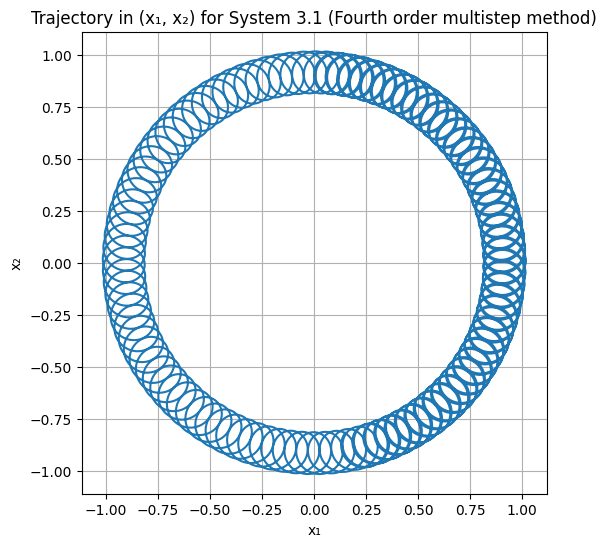

In [52]:
Tmax = 100
h = 0.1
N = int(Tmax / h)

x_2D, _ = fourth_order_multistep(x0_particle, v0_particle, B_particle, A_particle, A_particle_jacobian, gradU_particle, h, N)

plt.figure(figsize=(6,6))
plt.plot(x_2D[:,0], x_2D[:,1])
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.title("Trajectory in (x₁, x₂) for System 3.1 (Fourth order multistep method)")
plt.axis("equal")
plt.grid(True)
plt.show()

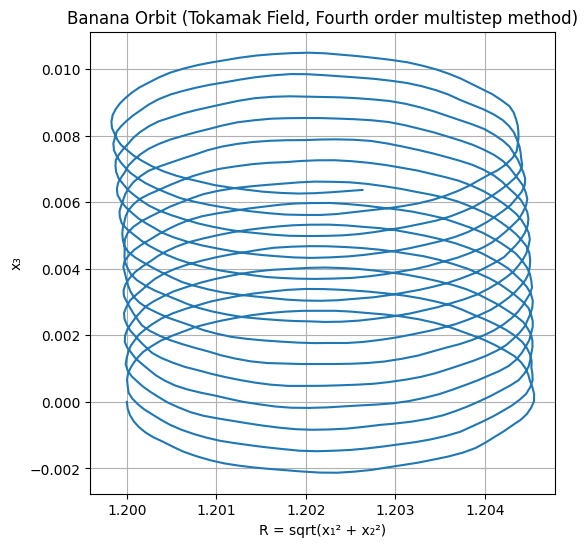

In [53]:
# TODO: gir feil svar (?). Prøv å regne ut jacobian numerisk istedet?
x_tok, _ = fourth_order_multistep(x0_tokamak, v0_tokamak, B_tokamak, A_tokamak, A_tokamak_jacobian, gradU_tokamak, h, Tmax)
#x_tok, _ = initial_soln(x0_tokamak, v0_tokamak, B_tokamak, gradU_tokamak, h, Tmax)

R = np.sqrt(x_tok[:,0]**2 + x_tok[:,1]**2)

plt.figure(figsize=(6,6))
plt.plot(R, x_tok[:,2])
plt.xlabel("R = sqrt(x₁² + x₂²)")
plt.ylabel("x₃")
plt.title("Banana Orbit (Tokamak Field, Fourth order multistep method)")
plt.grid(True)
plt.show()

### Error plots

In [54]:
particle_reference_soln, _ = initial_soln(x0_particle, v0_particle, B_particle, gradU_particle, h, Tmax)
tokamak_reference_soln, _ = initial_soln(x0_tokamak, v0_tokamak, B_tokamak, gradU_tokamak, h, Tmax)


def plot_error(x):
    N = int(Tmax / h)
    t = np.linspace(0, Tmax, N)
    error = np.linalg.norm(x - particle_reference_soln, axis=1)
    assert error.shape == (N,)
    plt.semilogy(t, error)

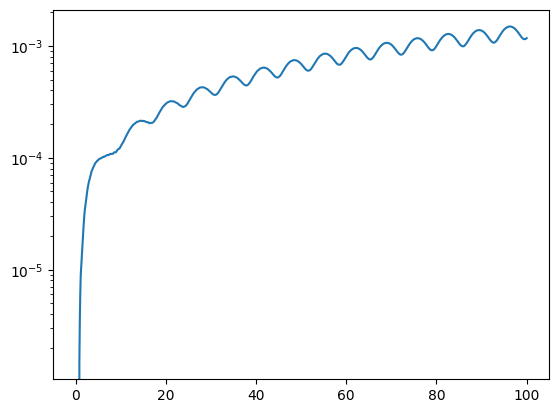

In [55]:
x, v = fourth_order_multistep(x0_particle, v0_particle, B_particle, A_particle, A_particle_jacobian, gradU_particle, h, Tmax)




plot_error(x)

B. Order verification and work precision diagrams

In [56]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as onp


# helper: reference solution (high accuracy)
def make_rhs(B_func, gradU_func):
    def rhs(t, y):
        x = y[:3]
        v = y[3:]
        dxdt = v
        dvdt = onp.cross(v, onp.array(B_func(onp.array(x)))) - onp.array(gradU_func(onp.array(x)))
        return onp.concatenate((dxdt, dvdt))
    return rhs

def reference_at_T(x0, v0, B_func, gradU_func, T):
    y0 = onp.concatenate([onp.array(x0).astype(float), onp.array(v0).astype(float)])
    rhs = make_rhs(B_func, gradU_func)
    sol = solve_ivp(rhs, (0.0, T), y0, rtol=1e-12, atol=1e-14)
    xt = sol.y[:3, -1]
    vt = sol.y[3:, -1]
    return onp.array(xt), onp.array(vt)

In [57]:
# runs methods and returns x(T) and time
def run_boris(x0, v0, B_func, gradU_func, h, T):
    start = time.perf_counter()
    x_all, v_half = boris_integrate(x0, v0, T, h, B_func, gradU_func)  # returns (N+1,3)
    end = time.perf_counter()
    
    xT = onp.array(x_all[-1], dtype=float)
    return xT, end - start

def run_rk4(x0, v0, B_func, gradU_func, h, T):
    
    start = time.perf_counter()
    xs, vs = rk4(T, h, x0, v0, B_func, None, None, gradU_func)  
    end = time.perf_counter()
    
    xT = onp.array(xs[int(T/h) - 1], dtype=float)
    return xT, end - start

def run_multistep(x0, v0, B_func, A_func, A_diff_func, gradU_func, h, T):
    start = time.perf_counter()

    x_arr, v_arr = fourth_order_multistep(x0, v0, B_func, A_func, A_diff_func, gradU_func, h, T)
    end = time.perf_counter()
   
    nsteps = int(T / h)
    xT = onp.array(x_arr[nsteps - 1], dtype=float)
    return xT, end - start

In [58]:
# compute errors and runtimes for h, h/2, h/4 
def experiment_on_system(name, x0, v0, B_func, A_func, A_diff_func, gradU_func,
                         methods, h0=0.1, T=10.0):

    h_vals = [h0, h0/2.0, h0/4.0]
    ref_xT, ref_vT = reference_at_T(x0, v0, B_func, gradU_func, T)
    print(f"[{name}] reference computed at T={T}")
    results = {}
    for label, runner, extra_args in methods:
        errors = []
        times = []
        for h in h_vals:
            # run and get numerical final x
            if runner is run_multistep:
                xT, tcost = runner(x0, v0, *extra_args, h, T)
            else:
                xT, tcost = runner(x0, v0, *extra_args, h, T)
            err = onp.linalg.norm(xT - ref_xT)
            errors.append(err)
            times.append(tcost)
            print(f"  {label} h={h:.5f} error={err:.3e} time={tcost:.3f}s")
        results[label] = {'h': onp.array(h_vals), 'err': onp.array(errors), 'time': onp.array(times)}
    return results


In [59]:
# define methods list for both systems 

boris_runner = ( "Boris", run_boris, (B_particle, gradU_particle) )
rk4_runner   = ( "RK4",   run_rk4,   (B_particle, gradU_particle) )
mult_runner  = ( "Symmetric4", run_multistep, (B_particle, A_particle, A_particle_jacobian, gradU_particle) )


methods_particle = [
    ("Boris", run_boris, (B_particle, gradU_particle)),
    ("RK4",   run_rk4,   (B_particle, gradU_particle)),
    ("Symmetric4", run_multistep, (B_particle, A_particle, A_particle_jacobian, gradU_particle))
]

methods_tokamak = [
    ("Boris", run_boris, (B_tokamak, gradU_tokamak)),
    ("RK4",   run_rk4,   (B_tokamak, gradU_tokamak)),
    ("Symmetric4", run_multistep, (B_tokamak, A_tokamak, A_tokamak_jacobian, gradU_tokamak))
]

In [62]:
# run experiments (choose small T to make it fast)
import time

h0 = 0.1
T = 10.0    
print("Running particle (3.1) experiments ...")
results_particle = experiment_on_system("2D particle (3.1)", x0_particle, v0_particle,
                                       B_particle, A_particle, A_particle_jacobian, gradU_particle,
                                       methods_particle, h0=h0, T=T)

print("\nRunning tokamak (3.2) experiments ...")
results_tokamak = experiment_on_system("Tokamak (3.2)", x0_tokamak, v0_tokamak,
                                       B_tokamak, A_tokamak, A_tokamak_jacobian, gradU_tokamak,
                                       methods_tokamak, h0=h0, T=T)

Running particle (3.1) experiments ...
[2D particle (3.1)] reference computed at T=10.0
  Boris h=0.10000 error=7.576e-04 time=0.012s
  Boris h=0.05000 error=1.891e-04 time=0.022s
  Boris h=0.02500 error=4.722e-05 time=0.038s
  RK4 h=0.10000 error=2.168e-02 time=0.025s
  RK4 h=0.05000 error=1.083e-02 time=0.039s
  RK4 h=0.02500 error=5.416e-03 time=0.090s
  Symmetric4 h=0.10000 error=2.172e-02 time=0.187s
  Symmetric4 h=0.05000 error=1.084e-02 time=0.386s
  Symmetric4 h=0.02500 error=5.416e-03 time=0.785s

Running tokamak (3.2) experiments ...
[Tokamak (3.2)] reference computed at T=10.0
  Boris h=0.10000 error=2.668e-05 time=0.010s
  Boris h=0.05000 error=6.668e-06 time=0.019s
  Boris h=0.02500 error=1.667e-06 time=0.036s
  RK4 h=0.10000 error=2.114e-04 time=0.022s
  RK4 h=0.05000 error=1.057e-04 time=0.045s
  RK4 h=0.02500 error=5.286e-05 time=0.097s
  Symmetric4 h=0.10000 error=8.444e-03 time=0.299s
  Symmetric4 h=0.05000 error=6.987e-03 time=0.545s
  Symmetric4 h=0.02500 error=6.38

In [63]:
# plotting helpers
def plot_order(results, system_name):
    plt.figure(figsize=(6,5))
    for label, data in results.items():
        h = data['h']
        err = data['err']
        plt.loglog(h, err, 'o-', label=label)
        
        coeffs = onp.polyfit(onp.log(h), onp.log(err+1e-30), 1)
        slope = coeffs[0]
        plt.text(h[-1], err[-1]*1.2, f"{slope:.2f}", fontsize=9)

    ref_h = results[list(results.keys())[0]]['h']
    ref_err = results[list(results.keys())[0]]['err']
    scale = ref_err[0] / (ref_h[0]**2)
    plt.loglog(ref_h, scale * (ref_h**2), 'k--', label='O(h^2)')
    scale4 = ref_err[0] / (ref_h[0]**4)
    plt.loglog(ref_h, scale4 * (ref_h**4), 'k-.', label='O(h^4)')
    plt.xlabel("step size h")
    plt.ylabel("global error ‖x(T)-x_ref(T)‖₂")
    plt.title(f"Order verification — {system_name}")
    plt.legend()
    plt.grid(True, which='both')
    plt.show()

def plot_work_precision(results, system_name):
    plt.figure(figsize=(6,5))
    for label, data in results.items():
        plt.loglog(data['time'], data['err'], 'o-', label=label)
    plt.xlabel("CPU time [s]")
    plt.ylabel("global error")
    plt.title(f"Work–precision diagram — {system_name}")
    plt.legend()
    plt.grid(True, which='both')
    plt.show()


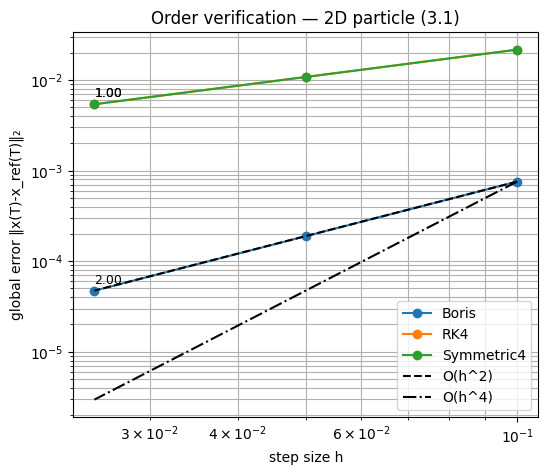

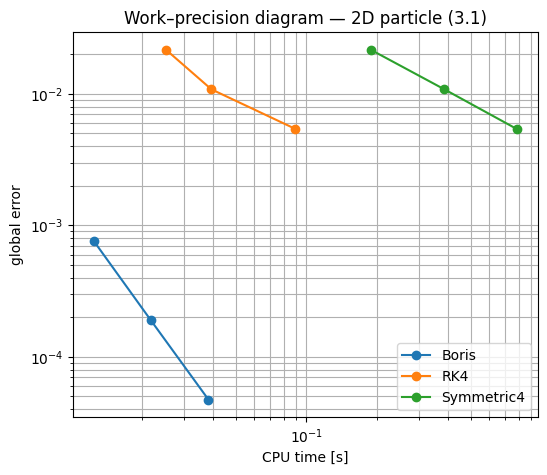

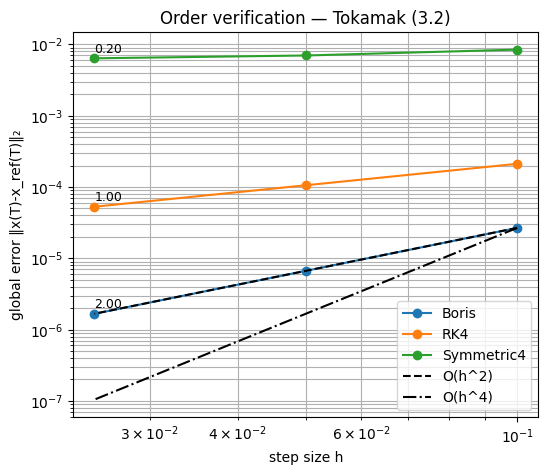

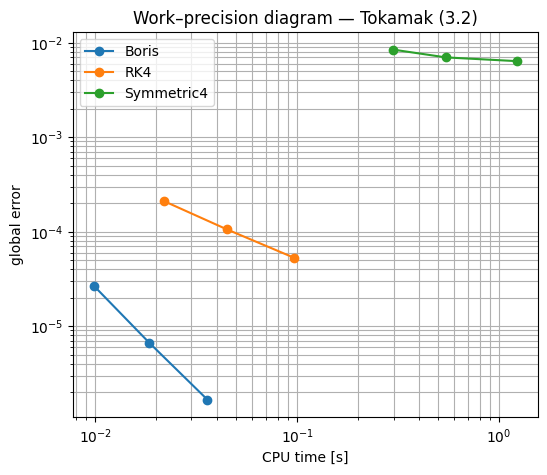

In [64]:
# show plots for particle and tokamak 
plot_order(results_particle, "2D particle (3.1)")
plot_work_precision(results_particle, "2D particle (3.1)")

plot_order(results_tokamak, "Tokamak (3.2)")
plot_work_precision(results_tokamak, "Tokamak (3.2)")